Dataset is available [here](https://drive.google.com/drive/folders/15PAAYJqQaVGDTLvTY1mrFjwELkTOhaIQ?usp=sharing) 
and the trained models are uploaded in this [location](https://drive.google.com/drive/folders/1KQR-F4wjlyejKBp_QWSUINeNkoYOTChP?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
# print(os.path.exists('/content/drive/MyDrive/Colab-Notebooks/covidDataset'))
# datapath = "../../../../datasets/covidDataset"
path = '/content/drive/MyDrive/covidDataset'
datapath = '/content/drive/MyDrive/covidDataset/dataset'
print(os.path.exists(datapath))

True


In [ ]:
import tensorflow as tf

In [ ]:
#if set_memory_growth is enabled, the runtime initialization will not allocate all memory on the device. 
#Memory growth cannot be configured on a PhysicalDevice with virtual devices configured.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
import pathlib

def get_imagepath_and_labels(datapath):
    data_root = pathlib.Path(datapath)
    all_image_path = [str(path) for path in list(data_root.glob('*/*'))]

    label_names = sorted(item.name for item in data_root.glob('*/*'))

    all_image_label = [pathlib.Path(single_image_path).parent.name for single_image_path in all_image_path]

    return all_image_path, all_image_label

all_image_path, all_image_label = get_imagepath_and_labels(datapath)

In [ ]:
import numpy as np

def get_images_and_labels_astensor(image_path, image_labels, channels):
    '''
    target_size is to resize the image.
    '''
    images = []
    labels = []
    for i in range(0, len(image_path)):
        image = image_astensor(image_path[i], channels=channels)
        images.append(image)
        labels.append(image_labels[i])
    
    images = np.array(images, dtype=object)
    labels = np.array(labels, dtype=object)
    return images, labels

def image_astensor(image_path, channels):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=channels)
        # image = tf.image.resize(image, target_size)
        # image = tf.cast(image, tf.float32 )
        # image = image / 255
        return image

images, labels = get_images_and_labels_astensor(all_image_path, all_image_label, channels=3)

print(images.shape)
print(labels.shape)

(2481,)
(2481,)


In [ ]:
print(type(images))
print(type(labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
print(images.shape)
print(labels.shape)

(2481,)
(2481,)


In [ ]:
print(np.unique(labels, return_counts=True))

(array(['COVID', 'non-COVID'], dtype=object), array([1252, 1229]))


In [ ]:
from sklearn.model_selection import train_test_split
 
X_train_original, X_test_original, y_train, y_test = train_test_split(
    images, 
    labels, 
    test_size=400, 
    shuffle=True,
    random_state=42,
    stratify=labels
)

print(X_train_original.shape)
print(y_train.shape)
print(X_test_original.shape)
print(y_test.shape)

(2081,)
(2081,)
(400,)
(400,)


In [ ]:
X_train_original, X_valid_original, y_train, y_valid = train_test_split(
    X_train_original, 
    y_train, 
    test_size=281, 
    shuffle=True,
    random_state=42,
    stratify=y_train
)


print(X_train_original.shape)
print(y_train.shape)
print(X_test_original.shape)
print(y_test.shape)
print(X_valid_original.shape)
print(y_valid.shape)

(1800,)
(1800,)
(400,)
(400,)
(281,)
(281,)


In [ ]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_valid, return_counts=True))
print(np.unique(y_test, return_counts=True)) 

(array(['COVID', 'non-COVID'], dtype=object), array([908, 892]))
(array(['COVID', 'non-COVID'], dtype=object), array([142, 139]))
(array(['COVID', 'non-COVID'], dtype=object), array([202, 198]))


In [ ]:
X_train1 = X_train_original[:600]
X_train2 = X_train_original[600:1200]
X_train3 = X_train_original[1200:1800]
print(X_train1.shape)
print(X_train2.shape)
print(X_train3.shape)

(600,)
(600,)
(600,)


In [ ]:
import torchvision.transforms as transforms
# transforms using pytorch api
train_transformer1 = transforms.Compose([
                        transforms.Resize(256),
                        transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor()
])

train_transformer2 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_transformer3 = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

test_transformer = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor()
])

valid_transformer = transforms.Compose([
                        transforms.Resize((224, 224)),
                        # transforms.CenterCrop(224),
                        transforms.ToTensor()
])

In [ ]:
from PIL import Image

In [ ]:
def transforms_on_image(tf_image, transformation):
    np_image = np.asarray(tf_image)
    pil_image = Image.fromarray(np_image, mode='RGB')
    # print(type(pil_image))
    # print(pil_image.size)
    assert len(pil_image.getbands()) == 3, "something wrong with the input image, may be not 3 dimensional" 


    torch_image = transformation(pil_image)
    torch_image = torch_image.permute(1, 2, 0)

    augmented_image = np.asarray(torch_image)
    augmented_image = tf.convert_to_tensor(augmented_image, dtype=tf.float32)
    return augmented_image
def transform_set(images, transformation):
    aug_images = []
    for i in range(0, len(images)):
        aug_images.append(transforms_on_image(images[i], transformation))
    
    aug_images = np.array(aug_images)
    return aug_images

In [ ]:
X_train1 = transform_set(X_train1, train_transformer1)
print(X_train1.shape)
X_train2 = transform_set(X_train2, train_transformer2)
print(X_train2.shape)
X_train3 = transform_set(X_train3, train_transformer3)
print(X_train3.shape)

(600, 224, 224, 3)
(600, 224, 224, 3)
(600, 224, 224, 3)


In [ ]:
X_test = transform_set(X_test_original, test_transformer)
print(X_test.shape)

X_valid = transform_set(X_valid_original, test_transformer)
print(X_valid.shape)

X_test_original = transform_set(X_test_original, valid_transformer)
print(X_test_original.shape)

X_valid_original = transform_set(X_valid_original, valid_transformer)
print(X_valid_original.shape)

(400, 224, 224, 3)
(281, 224, 224, 3)
(400, 224, 224, 3)
(281, 224, 224, 3)


In [ ]:
# to suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.preprocessing import LabelEncoder
# prepare target

def prepare_targets(y_train, y_test, y_valid):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    y_valid_enc = le.transform(y_valid)
    return y_train_enc, y_test_enc, y_valid_enc

y_train_enc, y_test_enc, y_valid_enc = prepare_targets(y_train, y_test, y_valid)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train_enc, 2)
y_test_cat = to_categorical(y_test_enc, 2)
y_valid_cat = to_categorical(y_valid_enc, 2)

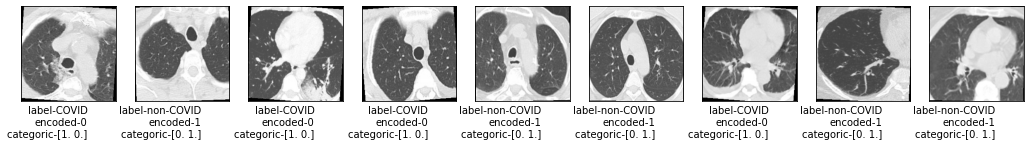

In [ ]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 4))

for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_train3[i])
    ax.text(0.7, -0.4, "label-{0}\nencoded-{1}\ncategoric-{2}".format(y_train[i], y_train_enc[i], y_train_cat[i]),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, fontsize=10)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# converting the data to tf.tensor
X_train1 = tf.convert_to_tensor(X_train1)
X_train2 = tf.convert_to_tensor(X_train2)
X_train3 = tf.convert_to_tensor(X_train3)
X_test = tf.convert_to_tensor(X_test)
X_valid = tf.convert_to_tensor(X_valid)
y_train_enc = tf.convert_to_tensor(y_train_enc)

y_test_enc = tf.convert_to_tensor(y_test_enc)
y_valid_enc = tf.convert_to_tensor(y_valid_enc)
y_train_cat = tf.convert_to_tensor(y_train_cat)


y_test_cat = tf.convert_to_tensor(y_test_cat)
y_valid_cat = tf.convert_to_tensor(y_valid_cat)

In [ ]:
X_train = tf.concat([X_train1, X_train2, X_train3], 0)
print(X_train.shape)
print(y_train_cat.shape)

(1800, 224, 224, 3)
(1800, 2)


Plotting implementation

In [ ]:
import matplotlib.pyplot as plt
def plot_accuracy_and_loss(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '--r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, '--r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

Model Implementation

Loading vgg19 and adding layers

In [ ]:
vgg_model = tf.keras.applications.VGG19(weights='imagenet',
                                      include_top=False,
                                        input_shape=(224, 224, 3))
# vgg_model.summary()
vgg_model.trainable=False 

x = vgg_model.layers[-1].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1000, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(500, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(200, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
vgg_output = tf.keras.layers.Dense(2, activation='softmax')(x)

vgg = tf.keras.models.Model(vgg_model.input, vgg_output)
vgg._name='vgg19'
vgg.summary()

In [ ]:
model_checkpoint_path = path + '/models/test3/vgg-output1'
## callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=model_checkpoint_path,
                                                    save_weights_only=False,
                                                    monitor='val_loss',
                                                    mode='min',
                                                    save_best_only=True)
# model_earlystopping_callback = tf.keras.callbacks.EarlyStopping(
#                                                     monitor='val_loss',
#                                                     patience = 5,
#                                                     mode='min')

In [ ]:
vgg.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

vgg_history = vgg.fit(X_train, y_train_cat,
                    epochs=100,
                    batch_size = 16,
                    validation_data=(X_valid, y_valid_cat))

vgg.save(model_checkpoint_path)

In [ ]:
plot_accuracy_and_loss(vgg_history)

In [ ]:
test_loss, test_acc = vgg.evaluate(X_test_original,  y_test_cat)
print('Accuracy:', test_acc)
print('Loss: ', test_loss)

Part 2 - DenseNet 169 

In [ ]:
dense169_model = tf.keras.applications.DenseNet169(weights='imagenet',
                                      include_top=False,
                                        input_shape=(224, 224, 3)
                                      )
# dense169_model.summary()
dense169_model.trainable=False 

y = dense169_model.layers[-1].output
y = tf.keras.layers.Flatten()(y)
y = tf.keras.layers.Dropout(0.5)(y)
y = tf.keras.layers.Dense(1000, activation='relu')(y)
y = tf.keras.layers.Dropout(0.5)(y)
densenet_1_output = tf.keras.layers.Dense(2, activation='softmax')(y)

densenet_1 = tf.keras.models.Model(dense169_model.input, densenet_1_output)
densenet_1._name='densenet_1'
densenet_1.summary()

In [ ]:
model_checkpoint_path = path + '/models/test3/densenet-output2'
## callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=model_checkpoint_path,
                                                    save_weights_only=False,
                                                    monitor='val_loss',
                                                    mode='min',
                                                    save_best_only=True)

In [ ]:
densenet_1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

densenet_1_history = densenet_1.fit(X_train, y_train_cat,
                    epochs=100,
                    batch_size=16,
                    validation_data=(X_valid, y_valid_cat))
densenet_1.save(model_checkpoint_path)

In [ ]:
plot_accuracy_and_loss(densenet_1_history)

In [ ]:
test_loss, test_acc = densenet_1.evaluate(X_test_original,  y_test_cat)
print('Accuracy:', test_acc)
print('Loss: ', test_loss)

Part 3 - Densenet 169

In [ ]:
dense169_model2 = tf.keras.applications.DenseNet169(weights='imagenet',
                                      include_top=False,
                                        input_shape=(224, 224, 3)
                                      )
# dense169_model.summary()
dense169_model2.trainable=False 
# since the model is already loaded we load in again
z = dense169_model2.layers[-1].output
z = tf.keras.layers.Flatten()(z)
z = tf.keras.layers.Dropout(0.5)(z)
z = tf.keras.layers.Dense(1000, activation='relu')(z)
z = tf.keras.layers.Dropout(0.5)(z)
z = tf.keras.layers.Dense(500, activation='relu')(z)
z = tf.keras.layers.Dropout(0.5)(z)
z = tf.keras.layers.Dense(200, activation='relu')(z)
z = tf.keras.layers.Dropout(0.5)(z)
densenet_2_output = tf.keras.layers.Dense(2, activation='softmax')(z)

densenet_2 = tf.keras.models.Model(dense169_model2.input, densenet_2_output)
densenet_2._name='densenet_2'
densenet_2.summary()

In [ ]:
model_checkpoint_path = path + '/models/test3/densenet-output3'
## callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=model_checkpoint_path,
                                                    save_weights_only=False,
                                                    monitor='val_loss',
                                                    mode='min',
                                                    save_best_only=True)

In [ ]:
densenet_2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

densenet_2_history = densenet_2.fit(X_train, y_train_cat,
                    epochs=100,
                    batch_size = 16,
                    validation_data=(X_valid, y_valid_cat))

densenet_2.save(model_checkpoint_path)


In [ ]:
plot_accuracy_and_loss(densenet_2_history)

In [ ]:
test_loss, test_acc = densenet_2.evaluate(X_test_original, y_test_cat)
print('Accuracy:', test_acc)
print('Loss: ', test_loss)

Ensembling all the models

In [ ]:
print(X_train.shape)
print(y_train_enc.shape)

In [ ]:
vgg = tf.keras.models.load_model(path+'/models/test2/vgg-output1')
densenet_1 = tf.keras.models.load_model(path+'/models/test2/densenet-output2')
densenet_2 = tf.keras.models.load_model(path+'/models/test2/densenet-output3')

In [ ]:
# print(X_train.shape)
# train = tf.concat([X_train, X_train2, X_train3], 0)
# labels = tf.concat([y_train_enc, y_train2_enc, y_train3_enc], 0)
# print(train.shape)
# print(labels.shape)

In [ ]:
vgg.trainable = False
densenet_1.trainable = False
densenet_2.trainable = False
models = [vgg, densenet_1, densenet_2]
# to avoid conflicts with naming
for layer in models[0].layers:
    layer._name = layer.name + str('_0')
for layer in models[1].layers:
    layer._name = layer.name + str('_1')
for layer in models[2].layers:
    layer._name = layer.name + str('_2')

In [ ]:
# ensemble = tf.keras.models.load_model(path + "/models/test2/ensemble")

In [ ]:
average = tf.keras.layers.Average()([vgg.output, densenet_1.output, densenet_2.output])
dense = tf.keras.layers.Dense(1, activation='sigmoid')(average)

ensemble = tf.keras.Model([vgg.input, densenet_1.input, densenet_2.input], dense)

In [ ]:
# ensemble.summary()

In [ ]:
# from keras.utils.vis_utils import plot_model

In [ ]:
# plot_model(ensembled, to_file = 'new_model.png', dpi=50)

In [ ]:
ensemble.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [ ]:
model_checkpoint_path = path + '/models/test2/ensemble'
## callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=model_checkpoint_path,
                                                    save_weights_only=False,
                                                    monitor='loss',
                                                    mode='min',
                                                    save_best_only=False,
                                                    save_freq=565)

In [ ]:
ensemble_history = ensemble.fit([X_train, X_train, X_train],y_train_enc,
                                epochs=100,
                                validation_data=([X_valid, X_valid, X_valid], y_valid_enc),
                                batch_size = 16,
                                callbacks=[model_checkpoint_callback])

# ensemble.save(model_checkpoint_path)

In [ ]:
plot_accuracy_and_loss(ensemble_history)

In [ ]:
test_loss, test_acc = ensemble.evaluate([X_test, X_test, X_test],  y_test_enc)
print('Accuracy:', test_acc)
print('Loss: ', test_loss)

Load ensemble model for further evaluation of performance matrix

In [ ]:
ensemble = tf.keras.models.load_model(path + "/models/test2/ensemble")

NameError: ignored

In [ ]:
# from keras.utils.vis_utils import plot_model
# plot_model(ensemble, to_file = path + '/models/test2/ensemble.png', dpi=50)

In [ ]:
y_pred = ensemble.predict([X_test, X_test, X_test])

In [ ]:
num = 280
print(type(y_pred))
print(y_pred[num-10:num])
print(y_test_enc[num])
y_test_enc = np.array(y_test_enc)
print(type(y_test_enc))

<class 'numpy.ndarray'>
[[0.73241395]
 [0.9637867 ]
 [0.9599673 ]
 [0.01631308]
 [0.01631308]
 [0.01631308]
 [0.01631308]
 [0.01631308]
 [0.2702538 ]
 [0.9723483 ]]
tf.Tensor(1, shape=(), dtype=int64)
<class 'numpy.ndarray'>


In [ ]:
y_pred[y_pred > 0.3] = 1.0
y_pred[y_pred <= 0.3] = 0.0

In [ ]:
print(y_pred.shape)

(400, 1)


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

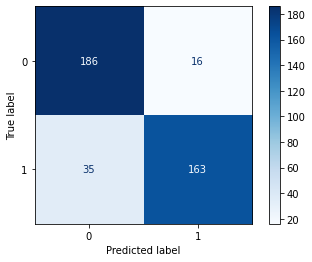

In [ ]:
cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import recall_score ,precision_score,accuracy_score, f1_score,roc_auc_score

In [ ]:
def binary_classification_performance(y_test, y_pred):
    tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
    accuracy = round(accuracy_score(y_pred = y_pred, y_true = y_test),2)
    precision = round(precision_score(y_pred = y_pred, y_true = y_test),2)
    recall = round(recall_score(y_pred = y_pred, y_true = y_test),2)
    f1_score = round(2*precision*recall/(precision + recall),2)
    specificity = round(tn/(tn+fp),2)
    npv = round(tn/(tn+fn),2)
    auc_roc = round(roc_auc_score(y_score = y_pred, y_true = y_test),2)


    result = pd.DataFrame({'Accuracy' : [accuracy],
                         'Precision (or PPV)' : [precision],
                         'Recall (senitivity or TPR)' : [recall],
                         'f1 score' : [f1_score],
                         'AUC_ROC' : [auc_roc],
                         'Specificty (or TNR)': [specificity],
                         'NPV' : [npv],
                         'True Positive' : [tp],
                         'True Negative' : [tn],
                         'False Positive':[fp],
                         'False Negative':[fn]})
    return result

In [ ]:
binary_classification_performance(y_test_enc, y_pred)
result3 = binary_classification_performance(y_test_enc, y_pred)

In [ ]:
y_pred = ensemble.predict([X_test_original, X_test_original, X_test_original])
y_pred[y_pred > 0.1] = 1.0
y_pred[y_pred <= 0.1] = 0.0
print("threshold - 0.1")
result1 = binary_classification_performance(y_test_enc, y_pred)
binary_classification_performance(y_test_enc, y_pred)

threshold - 0.1


,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.9,0.84,0.98,0.9,0.9,0.84,0.98,166,194,36,4


In [ ]:
y_pred = ensemble.predict([X_test_original, X_test_original, X_test_original])
y_pred[y_pred > 0.2] = 1.0
y_pred[y_pred <= 0.2] = 0.0
print("threshold - 0.2")
result2 = binary_classification_performance(y_test_enc, y_pred)
binary_classification_performance(y_test_enc, y_pred)

threshold - 0.2


,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.93,0.9,0.96,0.93,0.93,0.9,0.96,181,191,21,7


In [ ]:
y_pred = ensemble.predict([X_test_original, X_test_original, X_test_original])
y_pred[y_pred > 0.4] = 1.0
y_pred[y_pred <= 0.4] = 0.0
print("threshold - 0.4")
result4 = binary_classification_performance(y_test_enc, y_pred)
binary_classification_performance(y_test_enc, y_pred)

threshold - 0.4


,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.93,0.93,0.94,0.93,0.93,0.93,0.94,187,186,15,12


In [ ]:
y_pred = ensemble.predict([X_test_original, X_test_original, X_test_original])
y_pred[y_pred > 0.5] = 1.0
y_pred[y_pred <= 0.5] = 0.0
print("threshold - 0.5")
result5 = binary_classification_performance(y_test_enc, y_pred)
binary_classification_performance(y_test_enc, y_pred)

threshold - 0.5


,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.94,0.95,0.92,0.93,0.94,0.95,0.92,192,183,10,15


In [ ]:
y_pred = ensemble.predict([X_test_original, X_test_original, X_test_original])
y_pred[y_pred > 0.6] = 1.0
y_pred[y_pred <= 0.6] = 0.0
print("threshold - 0.6")
result6 = binary_classification_performance(y_test_enc, y_pred)
binary_classification_performance(y_test_enc, y_pred)

threshold - 0.6


,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.94,0.96,0.92,0.94,0.94,0.96,0.92,194,183,8,15


In [ ]:
y_pred = ensemble.predict([X_test_original, X_test_original, X_test_original])
y_pred[y_pred > 0.7] = 1.0
y_pred[y_pred <= 0.7] = 0.0
print("threshold - 0.7")
result7 = binary_classification_performance(y_test_enc, y_pred)
binary_classification_performance(y_test_enc, y_pred)

threshold - 0.7


,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.94,0.98,0.9,0.94,0.94,0.98,0.9,198,179,4,19


In [ ]:
y_pred = ensemble.predict([X_test_original, X_test_original, X_test_original])
y_pred[y_pred > 0.8] = 1.0
y_pred[y_pred <= 0.8] = 0.0
print("threshold - 0.8")
result8 = binary_classification_performance(y_test_enc, y_pred)
binary_classification_performance(y_test_enc, y_pred)

threshold - 0.8


,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.93,0.98,0.87,0.92,0.93,0.98,0.87,199,173,3,25


In [ ]:
y_pred = ensemble.predict([X_test_original, X_test_original, X_test_original])
y_pred[y_pred > 0.9] = 1.0
y_pred[y_pred <= 0.9] = 0.0
print("threshold - 0.9")
result9 = binary_classification_performance(y_test_enc, y_pred)
binary_classification_performance(y_test_enc, y_pred)

threshold - 0.9


,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.92,0.98,0.85,0.91,0.92,0.98,0.85,199,168,3,30


In [ ]:
results = [result1, result2, result3, result4, result5, result6, result7, result8, result9 ]

In [ ]:
accuracies = [i['Accuracy'] for i in results ]
recalls = [i['Recall (senitivity or TPR)'] for i in results ]
precisions = [i['Precision (or PPV)'] for i in results ]
f1s = [i['f1 score'] for i in results ]

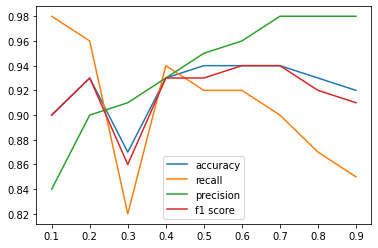

In [ ]:
X = np.linspace(0.1, 0.9, 9)
plt.plot(X, accuracies, label="accuracy")
plt.plot(X, recalls, label='recall')
plt.plot(X, precisions, label='precision')
plt.plot(X, f1s, label='f1 score')
plt.legend()
plt.show()

In [ ]:
results = pd.concat(results)

In [ ]:
results.insert(0, "Threshold", X, True)

In [ ]:
results = results.reset_index(drop=True)

In [ ]:
pd.set_option('precision', 3)

In [ ]:
results.style.highlight_max(color = 'black')

,Threshold,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.100,0.900,0.840,0.980,0.900,0.900,0.840,0.980,166,194,36,4
1,0.200,0.930,0.900,0.960,0.930,0.930,0.900,0.960,181,191,21,7
2,0.300,0.870,0.910,0.820,0.860,0.870,0.910,0.820,186,163,16,35
3,0.400,0.930,0.930,0.940,0.930,0.930,0.930,0.940,187,186,15,12
4,0.500,0.940,0.950,0.920,0.930,0.940,0.950,0.920,192,183,10,15
5,0.600,0.940,0.960,0.920,0.940,0.940,0.960,0.920,194,183,8,15
6,0.700,0.940,0.980,0.900,0.940,0.940,0.980,0.900,198,179,4,19
7,0.800,0.930,0.980,0.870,0.920,0.930,0.980,0.870,199,173,3,25
8,0.900,0.920,0.980,0.850,0.910,0.920,0.980,0.850,199,168,3,30


In [ ]:
y_pred = ensemble.predict([X_test, X_test, X_test])
y_pred[y_pred > 0.3] = 1.0
y_pred[y_pred <= 0.3] = 0.0
print("threshold - 0.3")
result9 = binary_classification_performance(y_test_enc, y_pred)
display(binary_classification_performance(y_test_enc, y_pred))

threshold - 0.3


,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.87,0.91,0.82,0.86,0.87,0.91,0.82,186,163,16,35
